In [1]:
import os
os.chdir('..')

In [2]:
# from google.colab import drive
# try: 
#   drive.mount('/content/drive')
# except:
#   print('Drive already mounted')

In [3]:
# import os
# os.chdir("/content/drive/MyDrive/DDP/Parametric_Roll_Detection")

In [9]:
from src.data.Dataset import Dataset as DS
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers

In [10]:
# Dataset generator
n = 10
m = 5
hop = 0.25
input_dim   = 30 * n
pred_dim    = 30 * m
shift       = pred_dim
batch_size  = 16
Data        = DS(
                input_dim, 
                pred_dim, 
                shift, 
                skip=0.25, 
                hop=hop, 
                batch_size=batch_size,
                in_cols=['roll']
                )

In [5]:
%load_ext autoreload
%autoreload 2

In [ ]:
# Loss functions
# Regression loss
MSE_loss = tf.keras.losses.MeanSquaredError()

# Metrics
# Regression metrics
MAPE = tf.keras.metrics.MeanAbsolutePercentageError()
MAE = tf.keras.metrics.MeanAbsoluteError()

In [ ]:
INPUT_DIM = Data.xshape
OUTPUT_DIM = Data.yshape

In [ ]:
print('Input dim:', INPUT_DIM)
print('Output dim:', OUTPUT_DIM)

Input dim: [1200, 1]
Output dim: [600, 1]


In [ ]:
# norm = tf.keras.layers.Normalization(input_shape=INPUT_DIM, axis=-1)
# x_ds = Data.Train.map(lambda x, y: x)
# norm.adapt(x_ds)

In [ ]:
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Normalization and Attention
    x = layers.LayerNormalization(epsilon=1e-6)(inputs)
    x = layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(x, x)
    x = layers.Dropout(dropout)(x)
    res = x + inputs

    # Feed Forward Part
    x = layers.LayerNormalization(epsilon=1e-6)(res)
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    return x + res

def build_model(
    input_shape,
    head_size,
    num_heads,
    ff_dim,
    num_transformer_blocks,
    mlp_units,
    dropout=0,
    mlp_dropout=0,
):
    inputs = keras.Input(shape=input_shape)
    x = inputs
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    x = layers.GlobalAveragePooling1D(data_format="channels_first")(x)
    for dim in mlp_units:
        x = layers.Dense(dim, activation="relu")(x)
        x = layers.Dropout(mlp_dropout)(x)
    outputs = layers.Dense(OUTPUT_DIM[0], activation="linear")(x)
    return keras.Model(inputs, outputs)

input_shape = INPUT_DIM

model = build_model(
    input_shape,
    head_size=256,
    num_heads=4,
    ff_dim=4,
    num_transformer_blocks=4,
    mlp_units=[1024],
    mlp_dropout=0.4,
    dropout=0.25,
)


In [ ]:
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=opt, loss=MSE_loss, metrics=[MAPE, MAE])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 1200, 1)]    0           []                               
                                                                                                  
 layer_normalization_8 (LayerNo  (None, 1200, 1)     2           ['input_2[0][0]']                
 rmalization)                                                                                     
                                                                                                  
 multi_head_attention_4 (MultiH  (None, 1200, 1)     7169        ['layer_normalization_8[0][0]',  
 eadAttention)                                                    'layer_normalization_8[0][0]']  
                                                                                            

In [ ]:
for x, y in Data.Train.take(1):
    out = model(x)
    print(out.shape)

(16, 600)


In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=15,
                                                    mode='min')

checkpoint_filepath = 'models/transformer/02/model'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='val_loss',
    mode='min',
    save_best_only=True)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                              patience=5, min_lr=0.000001)

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="models/transformer/02/metrics", update_freq=50)

In [ ]:
model.load_weights(checkpoint_filepath)

In [ ]:
model.fit(Data.Train, epochs=100, validation_data=Data.Val, callbacks=[early_stopping, model_checkpoint_callback, reduce_lr, tensorboard_callback])

Epoch 1/100
    429/Unknown - 468s 1s/step - loss: 15.4780 - mean_absolute_percentage_error: 190.5175 - mean_absolute_error: 2.4836

INFO:tensorflow:Assets written to: models/transformer/02/model/assets


INFO:tensorflow:Assets written to: models/transformer/02/model/assets


429/429 [==============================] - 497s 1s/step - loss: 15.4780 - mean_absolute_percentage_error: 190.5175 - mean_absolute_error: 2.4836 - val_loss: 8.9717 - val_mean_absolute_percentage_error: 317.2279 - val_mean_absolute_error: 1.5055 - lr: 0.1000
Epoch 2/100
429/429 [==============================] - ETA: 0s - loss: 15.4784 - mean_absolute_percentage_error: 193.6977 - mean_absolute_error: 1.9366

INFO:tensorflow:Assets written to: models/transformer/02/model/assets


INFO:tensorflow:Assets written to: models/transformer/02/model/assets


429/429 [==============================] - 492s 1s/step - loss: 15.4784 - mean_absolute_percentage_error: 193.6977 - mean_absolute_error: 1.9366 - val_loss: 8.9715 - val_mean_absolute_percentage_error: 319.4550 - val_mean_absolute_error: 1.5055 - lr: 0.1000
Epoch 3/100
429/429 [==============================] - ETA: 0s - loss: 15.4789 - mean_absolute_percentage_error: 193.6414 - mean_absolute_error: 1.9365

INFO:tensorflow:Assets written to: models/transformer/02/model/assets


INFO:tensorflow:Assets written to: models/transformer/02/model/assets


429/429 [==============================] - 492s 1s/step - loss: 15.4789 - mean_absolute_percentage_error: 193.6414 - mean_absolute_error: 1.9365 - val_loss: 8.9714 - val_mean_absolute_percentage_error: 321.2661 - val_mean_absolute_error: 1.5056 - lr: 0.1000
Epoch 4/100
429/429 [==============================] - ETA: 0s - loss: 15.4795 - mean_absolute_percentage_error: 193.4847 - mean_absolute_error: 1.9364

INFO:tensorflow:Assets written to: models/transformer/02/model/assets


INFO:tensorflow:Assets written to: models/transformer/02/model/assets


429/429 [==============================] - 492s 1s/step - loss: 15.4795 - mean_absolute_percentage_error: 193.4847 - mean_absolute_error: 1.9364 - val_loss: 8.9712 - val_mean_absolute_percentage_error: 322.5358 - val_mean_absolute_error: 1.5056 - lr: 0.1000
Epoch 5/100
429/429 [==============================] - ETA: 0s - loss: 15.4802 - mean_absolute_percentage_error: 193.2091 - mean_absolute_error: 1.9364

INFO:tensorflow:Assets written to: models/transformer/02/model/assets


INFO:tensorflow:Assets written to: models/transformer/02/model/assets


429/429 [==============================] - 492s 1s/step - loss: 15.4802 - mean_absolute_percentage_error: 193.2091 - mean_absolute_error: 1.9364 - val_loss: 8.9711 - val_mean_absolute_percentage_error: 323.2756 - val_mean_absolute_error: 1.5056 - lr: 0.1000
Epoch 6/100
429/429 [==============================] - ETA: 0s - loss: 15.4811 - mean_absolute_percentage_error: 192.8333 - mean_absolute_error: 1.9364

INFO:tensorflow:Assets written to: models/transformer/02/model/assets


INFO:tensorflow:Assets written to: models/transformer/02/model/assets


429/429 [==============================] - 492s 1s/step - loss: 15.4811 - mean_absolute_percentage_error: 192.8333 - mean_absolute_error: 1.9364 - val_loss: 8.9709 - val_mean_absolute_percentage_error: 323.6482 - val_mean_absolute_error: 1.5057 - lr: 0.1000
Epoch 7/100
429/429 [==============================] - ETA: 0s - loss: 15.4821 - mean_absolute_percentage_error: 192.3316 - mean_absolute_error: 1.9364

INFO:tensorflow:Assets written to: models/transformer/02/model/assets


INFO:tensorflow:Assets written to: models/transformer/02/model/assets


429/429 [==============================] - 490s 1s/step - loss: 15.4821 - mean_absolute_percentage_error: 192.3316 - mean_absolute_error: 1.9364 - val_loss: 8.9708 - val_mean_absolute_percentage_error: 323.8903 - val_mean_absolute_error: 1.5058 - lr: 0.1000
Epoch 8/100
429/429 [==============================] - ETA: 0s - loss: 15.4833 - mean_absolute_percentage_error: 191.8635 - mean_absolute_error: 1.9365

INFO:tensorflow:Assets written to: models/transformer/02/model/assets


INFO:tensorflow:Assets written to: models/transformer/02/model/assets


429/429 [==============================] - 486s 1s/step - loss: 15.4833 - mean_absolute_percentage_error: 191.8635 - mean_absolute_error: 1.9365 - val_loss: 8.9707 - val_mean_absolute_percentage_error: 324.2118 - val_mean_absolute_error: 1.5059 - lr: 0.1000
Epoch 9/100
 57/429 [==>...........................] - ETA: 6:36 - loss: 42.9643 - mean_absolute_percentage_error: 163.4025 - mean_absolute_error: 4.7928

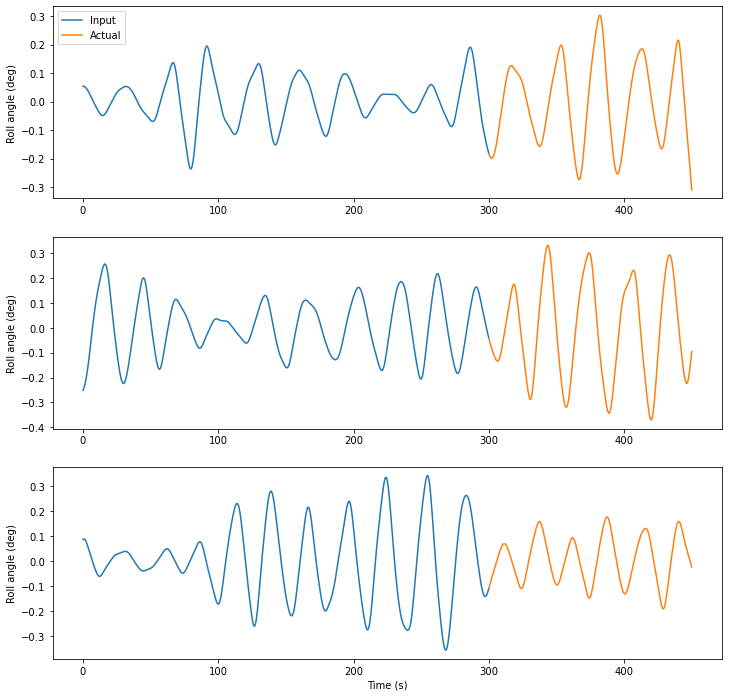

In [11]:
Data.plot_example(50)

In [ ]:
val_performance = model.evaluate(Data.Val)
test_performance = model.evaluate(Data.Test)

62/62 [==============================] - 40s 640ms/step - loss: 7.8260 - mean_absolute_percentage_error: 259.8730 - mean_absolute_error: 1.3493


In [ ]:
print('Validation MSE_loss: {:.2f}'.format(val_performance[0]))
print('Validation MAPE:     {:.2f}'.format(val_performance[1]))
print('Validation MAE:      {:.2f}'.format(val_performance[2]))
print('Test MSE_loss:       {:.2f}'.format(test_performance[0]))
print('Test MAPE:           {:.2f}'.format(test_performance[1]))
print('Test MAE:            {:.2f}'.format(test_performance[2]))

Validation MSE_loss: 5.76
Validation MAPE:     325.77
Validation MAE:      1.12
Test MSE_loss:       7.83
Test MAPE:           259.87
Test MAE:            1.35
